# Hybrid CV-DV Quantum Simulation: Conditional Displacement

Test suite for conditional displacement gate in CV-DV hybrid quantum system with 1 ancilla qubit.

In [1]:
# Imports
import numpy as np
import ctypes
from ctypes import c_int, c_double, POINTER
import matplotlib.pyplot as plt
import scienceplots
import subprocess
import os
from numpy import pi, sqrt

# Matplotlib configuration
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 18, 'text.usetex': True})

In [2]:
# Simulation parameters
DV_LEVEL = 1       # Number of qubits (1 ancilla qubit)
CV_LEVEL = 10      # Position grid resolution: 2^CV_LEVEL points
WIGNER_N = 201     # Wigner function grid size (NxN)
WIGNER_MAX = 5.0   # Wigner function range: [-WIGNER_MAX, WIGNER_MAX]
PLOT_X_RANGE = 6   # x-axis range for wavefunction plots

In [3]:
# Compile and load CUDA library
project_dir = os.path.dirname(os.path.abspath('__file__'))
build_dir = os.path.join(project_dir, 'build')

# Compile
result = subprocess.run(
    ['bash', os.path.join(project_dir, 'run.sh')],
    capture_output=True, text=True
)
print(result.stdout)
if result.returncode != 0:
    print(result.stderr)
    raise RuntimeError('Build failed')

# Load library
lib_path = os.path.join(build_dir, 'libcvdv.so')
lib = ctypes.CDLL(lib_path)

# Define C function signatures
# int cvdv_init(int dv_level, int cv_level)
lib.cvdv_init.argtypes = [c_int, c_int]
lib.cvdv_init.restype = c_int

# void cvdv_free()
lib.cvdv_free.argtypes = []
lib.cvdv_free.restype = None

# void cvdv_set_coherent(double alpha_re, double alpha_im)
lib.cvdv_set_coherent.argtypes = [c_double, c_double]
lib.cvdv_set_coherent.restype = None

# void cvdv_set_fock(int n)
lib.cvdv_set_fock.argtypes = [c_int]
lib.cvdv_set_fock.restype = None

# void cvdv_cd(double alpha_re, double alpha_im, int ctrl_qubit)
lib.cvdv_cd.argtypes = [c_double, c_double, c_int]
lib.cvdv_cd.restype = None

# void cvdv_pauli_rotation(int target_qubit, int axis, double theta)
lib.cvdv_pauli_rotation.argtypes = [c_int, c_int, c_double]
lib.cvdv_pauli_rotation.restype = None

# void cvdv_hadamard(int target_qubit)
lib.cvdv_hadamard.argtypes = [c_int]
lib.cvdv_hadamard.restype = None

# void cvdv_get_wigner(double* wigner_out, int wigner_n, double w_x_max, double w_p_max)
lib.cvdv_get_wigner.argtypes = [POINTER(c_double), c_int, c_double, c_double]
lib.cvdv_get_wigner.restype = None

# void cvdv_get_wigner_single_slice(double* wigner_out, int slice_idx, int wigner_n, double w_x_max, double w_p_max)
lib.cvdv_get_wigner_single_slice.argtypes = [POINTER(c_double), c_int, c_int, c_double, c_double]
lib.cvdv_get_wigner_single_slice.restype = None

# void cvdv_get_state(double* real_out, double* imag_out)
lib.cvdv_get_state.argtypes = [POINTER(c_double), POINTER(c_double)]
lib.cvdv_get_state.restype = None

# int cvdv_get_dv_level()
lib.cvdv_get_dv_level.argtypes = []
lib.cvdv_get_dv_level.restype = c_int

# int cvdv_get_dv_dim()
lib.cvdv_get_dv_dim.argtypes = []
lib.cvdv_get_dv_dim.restype = c_int

# int cvdv_get_cv_level()
lib.cvdv_get_cv_level.argtypes = []
lib.cvdv_get_cv_level.restype = c_int

# int cvdv_get_cv_dim()
lib.cvdv_get_cv_dim.argtypes = []
lib.cvdv_get_cv_dim.restype = c_int

# double cvdv_get_dx()
lib.cvdv_get_dx.argtypes = []
lib.cvdv_get_dx.restype = c_double

# void cvdv_get_dv_probs(double* probs_out)
lib.cvdv_get_dv_probs.argtypes = [POINTER(c_double)]
lib.cvdv_get_dv_probs.restype = None

print("Library compiled and loaded successfully!")

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/luxi/cuda-cvdv/build
[100%] Built target cvdv
Build successful: /home/luxi/cuda-cvdv/build/libcvdv.so

Library compiled and loaded successfully!


In [4]:
# CVDV Python wrapper class
class CVDV:
    """Python wrapper for CUDA CV-DV quantum simulator."""
    
    def __init__(self, dv_level: int = 0, cv_level: int = 10):
        """Initialize simulator with dv_level qubits and 2^cv_level grid points."""
        lib.cvdv_init(dv_level, cv_level)
        self.dv_level = lib.cvdv_get_dv_level()
        self.dv_dim = lib.cvdv_get_dv_dim()
        self.cv_level = lib.cvdv_get_cv_level()
        self.cv_dim = lib.cvdv_get_cv_dim()
        self.dx = lib.cvdv_get_dx()
    
    def __del__(self):
        """Free CUDA resources."""
        try:
            lib.cvdv_free()
        except:
            pass
    
    def set_coherent(self, alpha_re, alpha_im):
        """Set state to coherent state |α⟩."""
        lib.cvdv_set_coherent(alpha_re, alpha_im)
    
    def set_fock(self, n: int):
        """Set state to Fock state |n⟩."""
        lib.cvdv_set_fock(n)
    
    def cd(self, alpha, ctrl_qubit: int):
        """Apply conditional displacement gate CD(α).
        
        CD(α) = exp(Z (α a† - α* a))
        
        Args:
            alpha: Complex displacement parameter
            ctrl_qubit: Control qubit index
        """
        if isinstance(alpha, (int, float)):
            alpha = complex(alpha, 0.0)
        lib.cvdv_cd(alpha.real, alpha.imag, ctrl_qubit)
    
    def pauli_rotation(self, target_qubit: int, axis: int, theta: float):
        """Apply Pauli rotation. axis: 0=X, 1=Y, 2=Z"""
        lib.cvdv_pauli_rotation(target_qubit, axis, theta)
    
    def hadamard(self, target_qubit: int):
        """Apply Hadamard gate."""
        lib.cvdv_hadamard(target_qubit)
    
    def get_wigner(self, wigner_n: int = 101, w_x_max: float = 5.0, w_p_max: float = 5.0):
        """Compute Wigner function on a grid (summed over all qubit states)."""
        wigner = np.zeros(wigner_n * wigner_n, dtype=np.float64)
        lib.cvdv_get_wigner(
            wigner.ctypes.data_as(POINTER(c_double)),
            wigner_n, w_x_max, w_p_max
        )
        return wigner.reshape((wigner_n, wigner_n))
    
    def get_state(self):
        """Get full state vector as 2D array [qubit_idx, x_idx]."""
        total_size = self.dv_dim * self.cv_dim
        real_arr = np.zeros(total_size, dtype=np.float64)
        imag_arr = np.zeros(total_size, dtype=np.float64)
        lib.cvdv_get_state(
            real_arr.ctypes.data_as(POINTER(c_double)),
            imag_arr.ctypes.data_as(POINTER(c_double))
        )
        state = real_arr + 1j * imag_arr
        return state.reshape((self.dv_dim, self.cv_dim))
    
    def get_x_grid(self):
        """Get position grid points."""
        return (np.arange(self.cv_dim) - self.cv_dim // 2) * self.dx
    
    def get_dv_probs(self):
        """Get probability (norm squared * dx) for each DV slice."""
        probs = np.zeros(self.dv_dim, dtype=np.float64)
        lib.cvdv_get_dv_probs(probs.ctypes.data_as(POINTER(c_double)))
        return probs
    
    def get_wigner_by_qubit(self, qubit_state: int, wigner_n: int = 101, 
                             w_x_max: float = 5.0, w_p_max: float = 5.0):
        """Compute Wigner function for a specific qubit basis state slice using fast CUDA kernel.
        
        In a multi-qubit system, each basis state (e.g., |00⟩, |01⟩, |10⟩, |11⟩) represents
        a slice of the total Hilbert space. This computes the Wigner function for one such slice.
        
        Args:
            qubit_state: Integer index of the qubit basis state slice (e.g., 0=|0⟩, 1=|1⟩ for 1 qubit;
                        0=|00⟩, 1=|01⟩, 2=|10⟩, 3=|11⟩ for 2 qubits)
            wigner_n: Grid size for Wigner function
            w_x_max: Maximum x value
            w_p_max: Maximum p value
        """
        wigner = np.zeros(wigner_n * wigner_n, dtype=np.float64)
        lib.cvdv_get_wigner_single_slice(
            wigner.ctypes.data_as(POINTER(c_double)),
            qubit_state, wigner_n, w_x_max, w_p_max
        )
        return wigner.reshape((wigner_n, wigner_n))

print("CVDV class defined!")

CVDV class defined!


In [5]:
# Initialize with vacuum CV state and 1 qubit
sim = CVDV(dv_level=DV_LEVEL, cv_level=CV_LEVEL)

print(f"DV level: {sim.dv_level}, DV dim: {sim.dv_dim}")
print(f"CV level: {sim.cv_level}, CV dim: {sim.cv_dim}")
print(f"dx = {sim.dx:.6f}")
print(f"x range: [{-sim.cv_dim//2 * sim.dx:.2f}, {(sim.cv_dim//2 - 1) * sim.dx:.2f}]")

DV level: 1, DV dim: 2
CV level: 10, CV dim: 1024
dx = 0.078332
x range: [-40.11, 40.03]


## Test Conditional Displacement CD(α)

For a single qubit in superposition |+⟩ = (|0⟩ + |1⟩)/√2:
- CD(α)|+⟩|vac⟩ = (|0⟩|+α⟩ + |1⟩|-α⟩)/√2

After CD((1.5+1j)):
DV probabilities from CUDA: [0.5 0.5]
Sum of probs: 1.0000000000


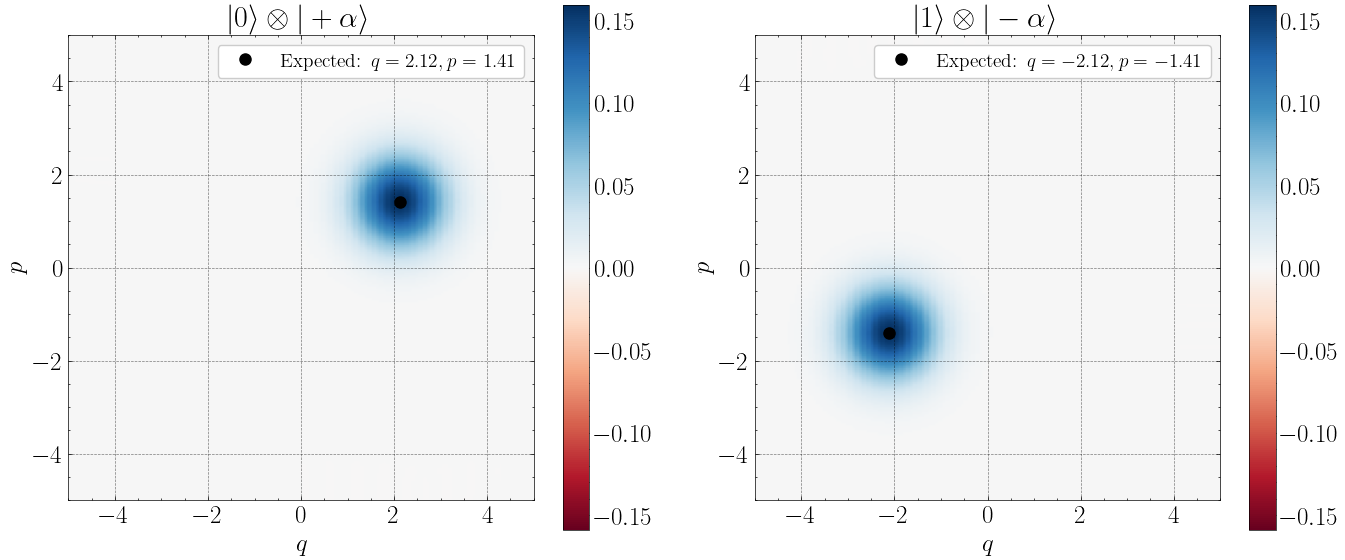

In [6]:
# Test with general complex displacement
sim.set_fock(0)  # Start with |0⟩ ⊗ |vac⟩
sim.hadamard(0)

# Apply conditional displacement with general complex α
alpha = 1.5 + 1.0j
sim.cd(alpha, ctrl_qubit=0)

# Check DV probabilities using CUDA kernel
probs = sim.get_dv_probs()
print(f"After CD({alpha}):")
print(f"DV probabilities from CUDA: {probs}")
print(f"Sum of probs: {np.sum(probs):.10f}")

# Compute individual Wigner functions for each qubit state
wigner_0 = sim.get_wigner_by_qubit(0, wigner_n=WIGNER_N, w_x_max=WIGNER_MAX, w_p_max=WIGNER_MAX)
wigner_1 = sim.get_wigner_by_qubit(1, wigner_n=WIGNER_N, w_x_max=WIGNER_MAX, w_p_max=WIGNER_MAX)

# Plot Wigner functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Wigner for |0⟩ component (should be centered at +α)
vmax = np.max(np.abs(wigner_0))
im1 = ax1.imshow(wigner_0, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                 origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
expected_q0 = sqrt(2) * alpha.real
expected_p0 = sqrt(2) * alpha.imag
ax1.plot(expected_q0, expected_p0, 'ko', markersize=8,
         label=rf'Expected: $q={expected_q0:.2f}, p={expected_p0:.2f}$')
ax1.set_xlabel(r'$q$')
ax1.set_ylabel(r'$p$')
ax1.set_title(rf'$|0\rangle \otimes |+\alpha\rangle$')
ax1.legend(fontsize=14)
plt.colorbar(im1, ax=ax1)

# Wigner for |1⟩ component (should be centered at -α)
vmax = np.max(np.abs(wigner_1))
im2 = ax2.imshow(wigner_1, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                 origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
expected_q1 = -sqrt(2) * alpha.real
expected_p1 = -sqrt(2) * alpha.imag
ax2.plot(expected_q1, expected_p1, 'ko', markersize=8,
         label=rf'Expected: $q={expected_q1:.2f}, p={expected_p1:.2f}$')
ax2.set_xlabel(r'$q$')
ax2.set_ylabel(r'$p$')
ax2.set_title(rf'$|1\rangle \otimes |-\alpha\rangle$')
ax2.legend(fontsize=14)
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()